# HW02 - Visualizing features of a pretrained VGG
In this homework, we are going to try to visualize what neurons encode through optimization.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


First, load the pretrained VGG model with torchvision, and print the architecture of the model.

In [3]:
### YOUR CODE HERE ###
model_vgg=models.vgg16(weights='DEFAULT')
model_vgg


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Part A - Visualizing the convolution filters

First, plot all the filters for the red channel of the first convolutional layer (there should be 64 filters in total). Can you find filters that seem to encode edges? Is this method useful for other layers?

Filters: torch.Size([64, 3, 3, 3])


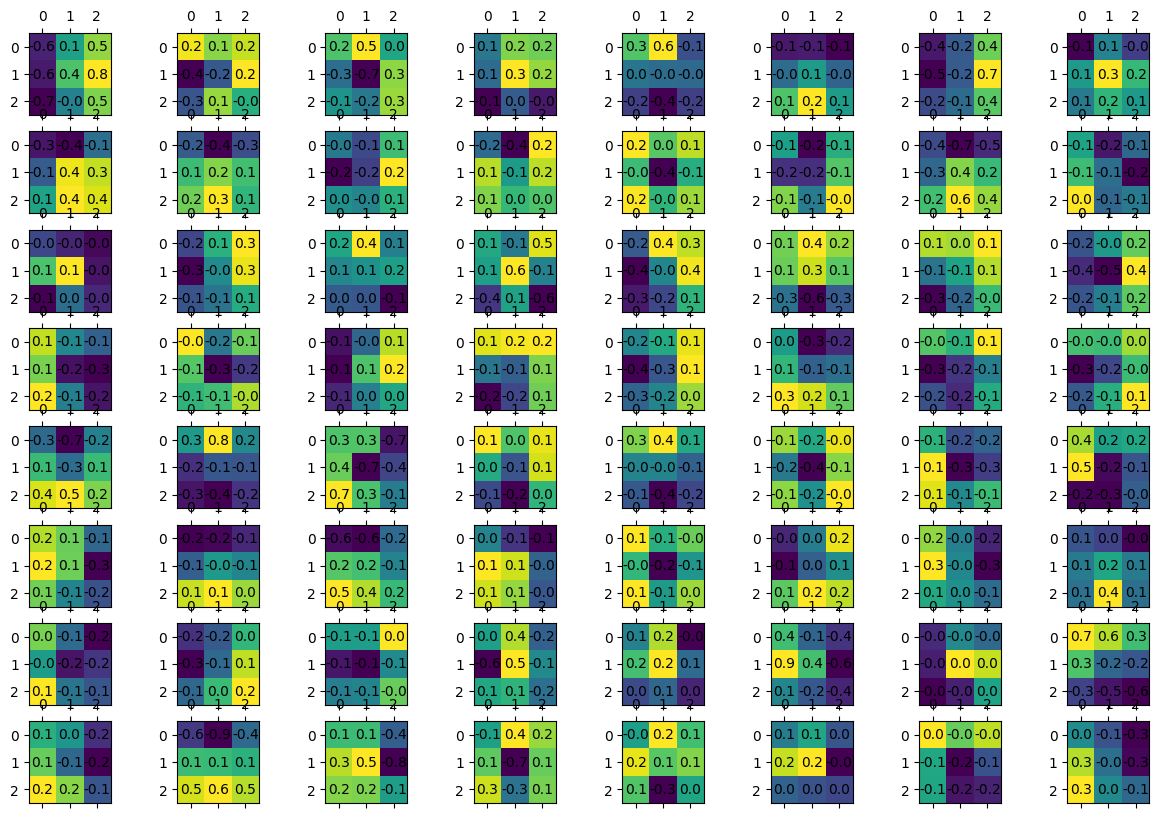

In [4]:
lay1=model_vgg.features[0]
print('Filters:', lay1.weight.size())
idxList=np.arange(64)
matList=[]

for id in idxList:
    matList.append(lay1.weight[id,0,:,:].detach().numpy())


fig, axs = plt.subplots(8,8)
#fig.suptitle('Convolution Matricies')
for i in idxList:
    axs[i//8, i%8].matshow(matList[i])
    for (k, j), z in np.ndenumerate(matList[i]):
        axs[i//8, i%8].text(j, k, '{:0.1f}'.format(z), ha='center', va='center')
fig.set_size_inches(15, 10)


These filters are directly applied to the image in question, so one can imagine what they do. For example the last filter detects diagonal lines going NorthWest to SouthEast. For sequential layers it becomes less intuitive.

# Part B - Visualizing channel activations through image optimization
## B.1 - First implementation
Create a module `ChannelActivation(layer, channel)` that returns the average activation (i.e. output value) of channel `channel` of layer `layer` of the VGG features.

In [5]:
### YOUR CODE HERE ###
def channelActivation(layer, channel):
    #print(model_vgg.features[layer].weight.size())

    try:
        lay=model_vgg.features[layer].weight
    except:
        lay=model_vgg.features[layer]
        print("ERROR, Layer is of incorrect type: ", lay)
        return None
    
    lay=lay[:,channel,:,:]
    avg=torch.sum(lay)/lay.size()[0]
    return avg
    

channelActivation(0,2)


tensor(0.0806, grad_fn=<DivBackward0>)

Our objective is to find which patterns are recognized by a given channel. To do so, we will follow the approach of [this Distill article](https://distill.pub/2017/feature-visualization/) and find images that lead to the highest possible channel activation.

First, create a random (colored) image of size 128x128, initialized with value at random between 0.4 and 0.6 (i.e. grey + small perturbation). Then, perform 200 steps of Adam (with lr=0.01) to maximize the activation of channel 4 of layer 1. Plot the image after 0, 10, 50, 100 and 200 iterations. You should see a pink saturated image with several horizontal lines, indicating that the channel probably recognizes horizontal edges.

**NB1:** Careful, by default, optimizers minimize their objective, not maximize it!

**NB2:** The parameters given to an optimizer should be on the cpu. If you use a gpu, you thus need to keep two versions of the image: 1) a cpu version given to the optimizer, and 2) a gpu version, created at each iteration of the optimization, and used to compute the gradient.

In [6]:
### YOUR CODE HERE ###

def avg_output(output, target_channel, epoch, showOutput=True):
    avg=torch.mean((output[target_channel, :, :]))

    if epoch%50==0 and showOutput:
        print("Output Channel " + str(target_channel) +":", avg.detach().numpy(), "Epoch:", epoch)

    return avg


def optimize_image(model, picture,channel, epoch, transform=None, showOutput=True):

    if transform is not None:
        picture=transform(picture)

    picture=nn.Parameter(picture.clone().detach().requires_grad_(True))
    optimizer=torch.optim.Adam([picture], lr=1e-2, maximize=True)

    optimizer.zero_grad()

    output=model(picture)
    mean=avg_output(output, channel, epoch, showOutput=showOutput)     
    mean.backward()
    optimizer.step()

    return picture




Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)
Output Channel 4: 0.49264854 Epoch: 50
Output Channel 4: 0.6074961 Epoch: 100
Output Channel 4: 0.75021243 Epoch: 150
Output Channel 4: 0.91975933 Epoch: 200


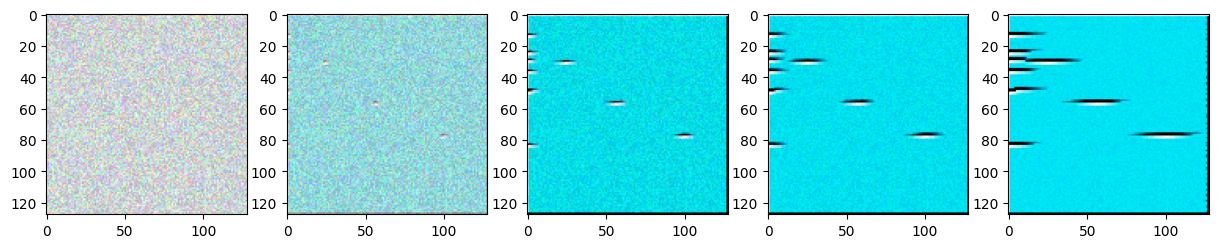

In [7]:
picture=torch.rand(3, 128, 128, requires_grad=True)

model_vgg=models.vgg16(weights='DEFAULT')
picture=0.4+picture/5
layer=1
layeridex=layer
channel=4
epochs=200

model=model_vgg.features[0:layeridex+1].eval()

print(model)

epochList=[1,10,50,100, epochs]
fig, axs = plt.subplots(1,len(epochList))

i=0
for epoch in range(1,epochs+1):

    picture=optimize_image(model, picture, channel, epoch)

    if epoch in epochList:
        pictureShow=picture.detach().numpy()
        transposed=np.zeros((128,128,3))
        for k in range(3):
            transposed[:,:,k]=pictureShow[k,:,:]
        
        transposed=transposed/np.max(transposed)
        transposed=np.clip(transposed, 0, 1)
        axs[i].imshow(transposed) 
        i+=1

fig.set_size_inches(15, 10)


## B.2 - Improving stability with clipping and normalization
Compute the highest and lowest values of the image. What is the issue?

In [8]:
print('Highest Value: ', torch.max(picture))
print('Lowest Value: ', torch.min(picture))
print("Problem: The indices take on values that are non-standard for plotting images")


Highest Value:  tensor(2.5997, grad_fn=<MaxBackward1>)
Lowest Value:  tensor(-1.5994, grad_fn=<MinBackward1>)
Problem: The indices take on values that are non-standard for plotting images


To avoid (over) saturation, clip the image pixels to $[0.2,0.8]$ after each optimization step using `input_image.data = input_image.data.clip(0.2, 0.8)`. You should now see several clear horizontal lines in a blue background.

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
)
Output Channel 4: 0.45710856 Epoch: 50
Output Channel 4: 0.45995462 Epoch: 100
Output Channel 4: 0.4627759 Epoch: 150
Output Channel 4: 0.4654769 Epoch: 200


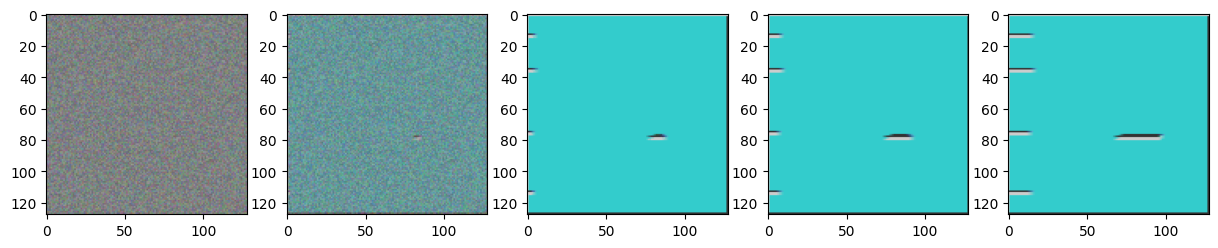

In [9]:
picture=torch.rand(3, 128, 128, requires_grad=True)

model_vgg=models.vgg16(weights='DEFAULT')
picture=0.4+picture/5
layer=1
layeridex=layer
channel=4
epochs=200

model=model_vgg.features[0:layeridex+1].eval()

print(model)

epochList=[1,10,50,100, epochs]
fig, axs = plt.subplots(1,len(epochList))

i=0
for epoch in range(1,epochs+1):

    picture=optimize_image(model, picture, channel, epoch)
    picture=picture.clip(0.2, 0.8)

    if epoch in epochList:
        pictureShow=picture.detach().numpy()
        transposed=np.zeros((128,128,3))
        for k in range(3):
            transposed[:,:,k]=pictureShow[k,:,:]
        
        axs[i].imshow(transposed) 
        i+=1

fig.set_size_inches(15, 10)

One issue with our current code, is that VGG was trained on **normalized** images, and thus is not adapted to our input image. To normalize the image, we will use **transforms**.

Create a function `create_activation_image(layer, channel, transform=None, image_size=128, show_steps=False)` that maximizes the corresponding channel activation on an image of size `image_size`, and first applies `transform` to the image before computing the gradient of the activation. The function should return the final image after 200 steps, and plot intermediate images for the steps 0,10,50,100,200 if `show_steps=True`.

Then, test your function with `transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`. Is this better? You should now see a horizontal pattern with lines.

In [10]:
### YOUR CODE HERE ###
def image_for_plotting(image, normalize=False):
    pictureShow=image.detach().numpy()
    if normalize:
        minval=np.min(pictureShow)
        maxval=np.max(pictureShow)
        pictureShow=(pictureShow-minval)/(maxval-minval)
    else:
         pictureShow=np.clip(pictureShow, 0, 1)

    shape=np.shape(pictureShow)
    transformed=np.zeros((shape[1],shape[2],3))
    for k in range(3):
        transformed[:,:,k]=pictureShow[k,:,:]

    return transformed


def create_activation_image(layer, channel, transform=None, image_size=128, show_steps=False, showOutput=True):
    model_vgg=models.vgg16(weights='DEFAULT')

    image=torch.rand(3, image_size, image_size, requires_grad=True)
    image=0.4+image/5
    image=transform(image)

    epochList=[1,10,50,100, epochs]

    model=model_vgg.features[0:layer+1].eval()
    #print(model)

    epochList=[0,10,50,100, 200]

    i=0
    if show_steps: 
            fig, axs = plt.subplots(1,len(epochList))
            fig.set_size_inches(15, 10)
            axs[i].imshow(image_for_plotting(image)) 
            i+=1

    for epoch in range(1,201):

        image=optimize_image(model, image, channel, epoch, showOutput=showOutput)

        if epoch in epochList and show_steps: 
            axs[i].imshow(image_for_plotting(image)) 
            i+=1

    return image

    

Output Channel 4: 1.5078336 Epoch: 50
Output Channel 4: 2.7300406 Epoch: 100
Output Channel 4: 3.9795792 Epoch: 150
Output Channel 4: 5.239689 Epoch: 200


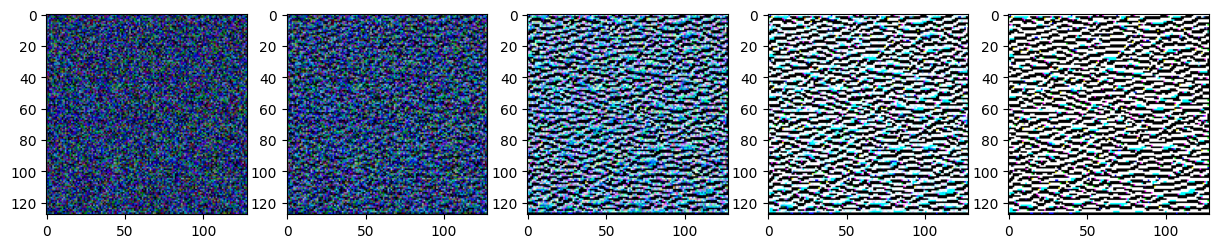

In [11]:
transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

image=create_activation_image(1,4, transform=transform, show_steps=True)

Now test your function on channel 0 of layer 20. The pattern that appears should vagely resemble fish scales.

Output Channel 0: 59.564934 Epoch: 50
Output Channel 0: 105.66744 Epoch: 100
Output Channel 0: 146.56952 Epoch: 150
Output Channel 0: 186.98991 Epoch: 200


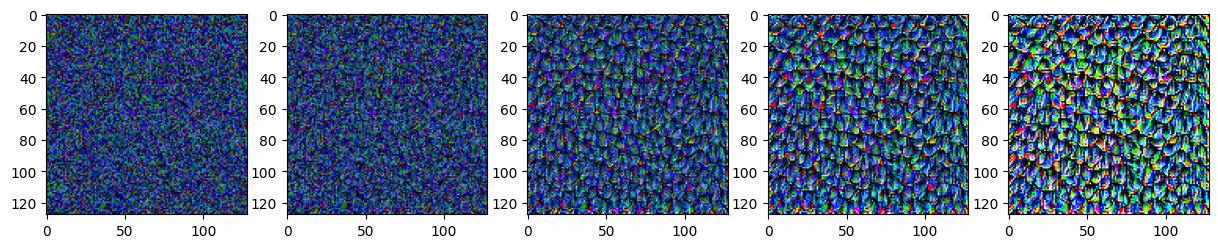

In [12]:
transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

image=create_activation_image(20,0, transform, show_steps=True)

## B.3 - Transformation robustness
Large neural network are prone to adversarial attacks, i.e. a small well-crafted additive noise can dramatically change the output of the model, and thus lead to incorrect classification. For our purpose, this is an issue, as the optimization algorithm may find such very specific noise instead of more valuable visual patterns.

To avoid this issue and further improve our images, we are thus going to apply small random perturbations to the image before computing the gradient. This will prevent the optimizer from optimizing the noise, and overall increase the stability of our process.

To do so, add a composition of several transforms (before the normalization):

1.   A small pixel noise with `transforms.Lambda(lambda x: x + 0.001 * (2 * torch.rand_like(x) - 1))`
2.   A random affine transform with `transforms.RandomAffine(degrees=5, translate=(0.1,0.1), scale=(0.9,1.1))`
3.   A random crop of size 96 (to reduce the size of the image)
4.   Random local fluctations with `transforms.ElasticTransform(alpha=50.)`

Compare the activation images with and without these random transformations. Is the pattern more visible?



Output Channel 0: 72.268394 Epoch: 50
Output Channel 0: 113.56285 Epoch: 100
Output Channel 0: 150.0845 Epoch: 150
Output Channel 0: 185.49667 Epoch: 200


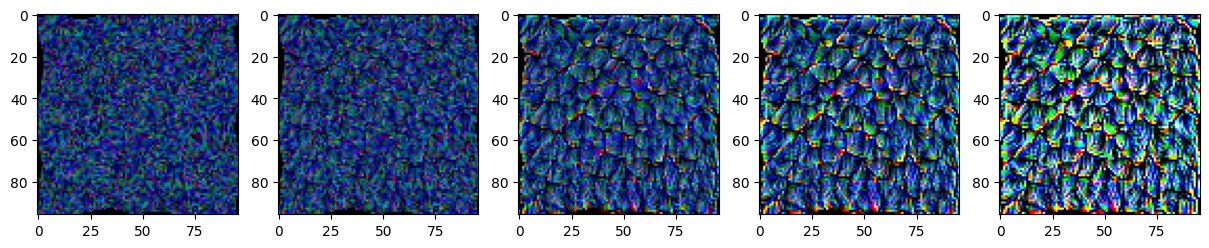

In [13]:
### YOUR CODE HERE ###

transform=transforms.Compose([
    transforms.Lambda(lambda x: x + 0.001 * (2 * torch.rand_like(x) - 1)),
    transforms.RandomAffine(degrees=5, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomCrop(size=96),
    transforms.ElasticTransform(alpha=50.),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image=create_activation_image(20,0, transform=transform, show_steps=True)

To see what the transformation is doing to an image, apply the random transformations (without normalization) to the following simple image, and show 5 randomly transformed images.

C:\Users\maxrl\AppData\Local\Temp\ipykernel_11540\501716626.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


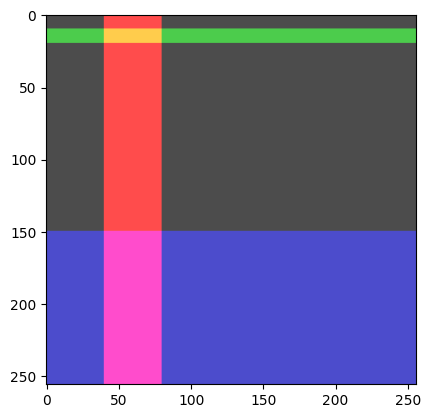

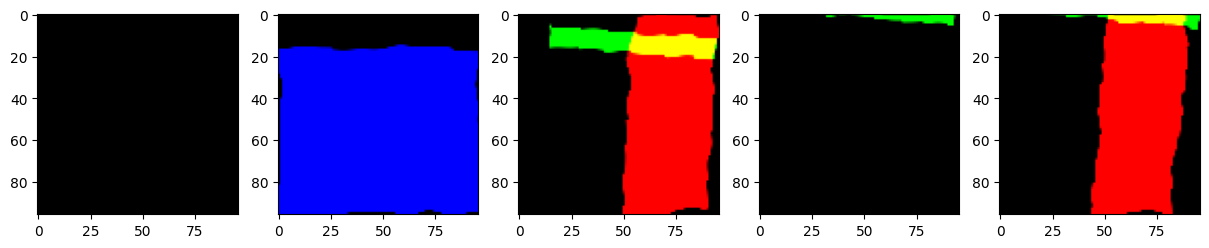

In [14]:
sample_image = 0.3 * torch.ones(3, 256, 256)
sample_image[0,:,40:80] += 0.7
sample_image[1,10:20,:] += 0.5
sample_image[2,150:,:] += 0.5
plt.imshow(image_for_plotting(sample_image))

nPics=5
fig, axs = plt.subplots(1, nPics)
fig.set_size_inches(15, 10)

for i in range(nPics):
    transformedImage=transform(sample_image)
    axs[i].imshow(image_for_plotting(transformedImage))

fig.show()



## B.4 - Final visualization
Finally, show the activation images for the first 5 channels of layers [1, 10, 20, 30]. You should be able to see a gradual complexification of the patterns.

**PS1:** Our method seems unable to find meaningful patterns for the last layer. One issue is probably that the random crop imposes that all regions on the image look similar (as they all should have a high channel activation), thus preventing larger and more complex patterns to emerge from the optimization.

**PS2:** You can also try other layers and channels to find interesting patterns!

Currently optimizing layer 1 of 4
Currently optimizing layer 2 of 4
Currently optimizing layer 3 of 4
Currently optimizing layer 4 of 4


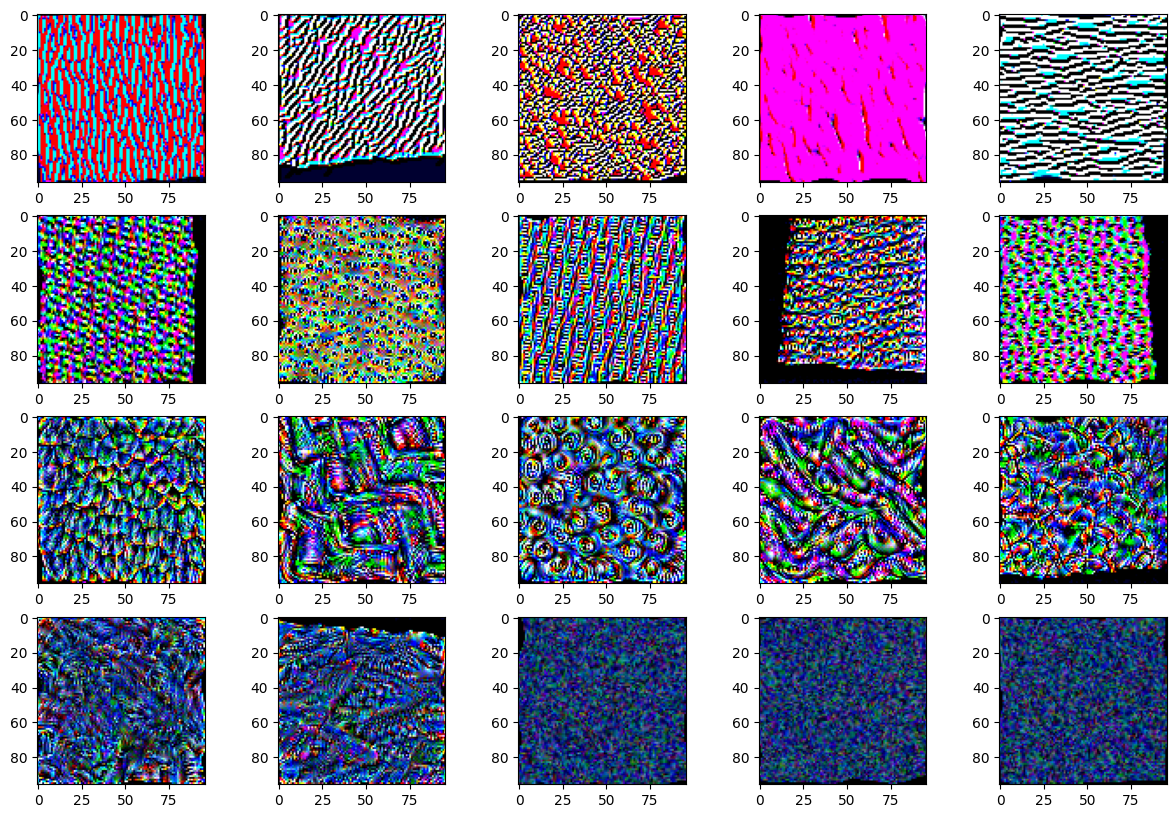

In [15]:
### YOUR CODE HERE ###
layers=[1,10, 20, 30]
fig, axs = plt.subplots(len(layers), nPics)
fig.set_size_inches(15, 10)
nPics=5


for i in range(len(layers)):
    print("Currently optimizing layer", i+1, "of", len(layers))
    layer=layers[i]
    for channel in range(nPics):
        img=create_activation_image(layer,channel, transform=transform, show_steps=False, showOutput=False)
        axs[i, channel].imshow(image_for_plotting(img))

    